In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [48]:
size = 5
index = (size - 1)/2
# x, y = np.meshgrid[-bound:bound+1, -bound:bound+1]
x, y = np.meshgrid(np.linspace(-index, index, size), np.linspace(-index, index, size))

In [46]:
# from mpl_toolkits import mplot3d

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(x, y, gaussian, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_title('surface');

In [87]:
import numpy as np
from numpy import sin, cos, sqrt, pi
from typing import List


# constants:
kernel_size = 14
# SCALES = [1/2 * sqrt(2), sqrt(2), 2]
SCALES = [0.5, 1, 1.4]
NORIENT = 6
NDOG = len(SCALES) * NORIENT
NROTINV = 12
TOTAL = 2*NDOG + NROTINV
F = np.zeros([kernel_size, kernel_size, TOTAL])

class LMLFilterBank:
    def __init__(self, size):
        bound = (size - 1) / 2
        spread = np.linspace(-bound, bound, size)

        self.x, self.y = np.meshgrid(spread, spread)

        self.pts = np.array([self.x.flatten(), self.y.flatten()])
        self.rotated_pts = self.pts

        # self.var = sigma * sigma

    def get_1d_gaussian(self, x: List[float], sigma: float) -> List[float]:
        """
        Calculates 1d gaussian using function definition at each point in x
        """
        x = x - np.mean(x)
        var = sigma * sigma

        num = np.exp(-(x * x) / 2 * var)
        denom = np.sqrt(2 * pi * var)

        return num / denom

    def get_2d_gaussian(grid: [List[List[float]]], sigma, elong_factor: float = 1) -> [List[List[float]]]:
        """
        Calculates 2d gaussian using function defn. at each point (x, y) in grid
        """
        x, y = grid[0], grid[1]

        sigma_y = sigma
        sigma_x = elong_factor * sigma_y

        num = np.exp(-0.5 * ((x**2 / sigma_x**2) + (y ** 2 / sigma_y**2)))
        denom = np.sqrt(2 * pi * sigma_x * sigma_y)

        return num / denom

    @staticmethod
    def get_deriv_of_1d_gaussian(order: int, x: List[float], sigma: float) -> List[float]:
        """
        Gets the 1st or 2nd order derivative of gaussian.
        """
        x = x - np.mean(x)
        var = sigma * sigma

        num = np.exp(-(x * x) / 2 * var)
        denom = np.sqrt(2 * pi * var)

        g = num / denom

        if order == 1:
            return (-x / var) * g
        else:  # order = 2
            return ((x * x - var) / (var * var)) * g

    def get_filter(self, order: int, pts: List[List[float]], sigma: float):
        """
        Gets the 1st or 2nd order derivative of gaussian.
        """
        gx = self.get_1d_gaussian(pts[0], 3*sigma)
        gy = self.get_deriv_of_1d_gaussian(order, pts[1], sigma)

        return np.reshape(gx * gy, (kernel_size, kernel_size))

    
    def get_LMLFilter_bank(self):
        count = 0
        for scale in SCALES:
            for orientation in range(NORIENT):
                angle = orientation * pi / NORIENT
                rotation_mat = np.array([[cos(angle)+0, -sin(angle)+0], [sin(angle)+0, cos(angle)+0]])
                rotated_pts = np.dot(rotation_mat, self.pts)
                F[:,:,count] = self.get_filter(1, rotated_pts, scale)
                F[:,:,count+NDOG] = self.get_filter(2, rotated_pts, scale)
                count += 1

        return F


In [88]:
lml_bank = LMLFilterBank(kernel_size)

In [89]:
filters = lml_bank.get_LMLFilter_bank()

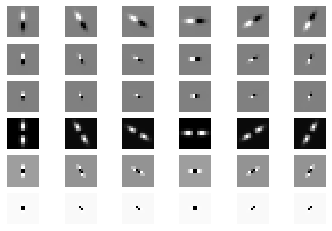

In [90]:
import matplotlib.pyplot as plt

for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

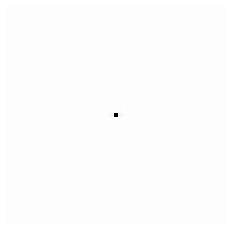

In [41]:
plt.axis('off')
plt.imshow(F[:,:,22], cmap = 'gray')

In [21]:
F.shape

(49, 49, 48)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g
    
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image


def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)  
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F

# Call the make filter function
F = makeLMfilters()

In [2]:
rotpts

NameError: name 'rotpts' is not defined

In [94]:
# plt.subplot(1,1,1)
# plt.axis('off')
# plt.imshow(gaussian, cmap = 'gray')


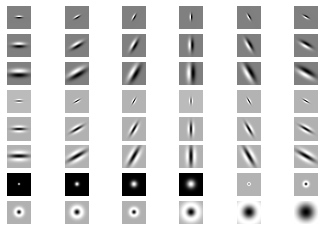

In [3]:
for i in range(48):
    plt.subplot(8,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

In [4]:
import cv2

canny_pb = cv2.imread("/home/radha/YourDirectoryID_hw0/Phase1/BSDS500/CannyBaseline/10.png")
canny_pb = cv2.cvtColor(canny_pb, cv2.COLOR_BGR2GRAY)

In [5]:
canny_pb.shape

(481, 321)